# Exponential Smoothing Models

In this notebook we will continue our learning path through one of the most used type of models when talking about time series forecasting: The exponential family. The content this time will be based on excellent [Hyndman's book](https://otexts.com/fpp3/expsmooth.html) and we will keep using data from last notebooks as well.

In [72]:
import sys
import logging

sys.path.append("../src/")

from utils import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

import statsmodels.tsa.api as smt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing datasets

In [2]:
def read_and_prep_data(filename):
    df =  (pd.read_csv(filename)
              .rename(columns=str.lower))
    
    if "date" in df.columns:
        # df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
        
    return df

df_elect_prod = read_and_prep_data('../data/raw/Electric_Production.csv')
df_temp_sp = read_and_prep_data('../data/raw/station_sao_paulo.csv')
df_fem_births = read_and_prep_data('../data/raw/daily-total-female-births.csv')
df_google_stock = read_and_prep_data('../data/raw/google_stock.csv')

In [3]:
from datetime import datetime

google_index = pd.to_datetime(list(map(lambda x: datetime(int(x[2]), int(x[1]), int(x[0])), df_google_stock.index.str.split("/"))))
df_google_stock.index = google_index

## Simple Exponential Smoothing

- It is a model recommended for data with no clear trend or seasonal factors.
- It is a weighted average of past values where we have a decreasing exponential factors for lags in distant past.

The equation is given by:

$$ \hat{y}_{T+1|T} = \alpha*y_{T} + \alpha(1-\alpha)*y_{T-1} + ..., $$
where
$$ 0 \le \alpha \le 1 $$
is a smoothing parameter.

The weights decrease exponentially as we back in time, and we can have two basic interpretations:
- if alpha is small, more weight is given for observations from more distant past.
- if alpha is close to 1, more weight is given for recent observations.
- if alpha = 1, then we have a naive forecast.

**Component Form**

We can also think of simple exponential smoothing as in its component form. Later we will see other components being added to our model, trend and seasonal.
So the basic for is:

- Forecast Equation: $ \hat{y}_{t+h|t} = l_{t} $
- Smoothing Equation: $ l_{t} = \alpha*y_{t} + (1 - \alpha)*l_{t-1} $

We can work a little on data to see the effects of varying alpha parameter.

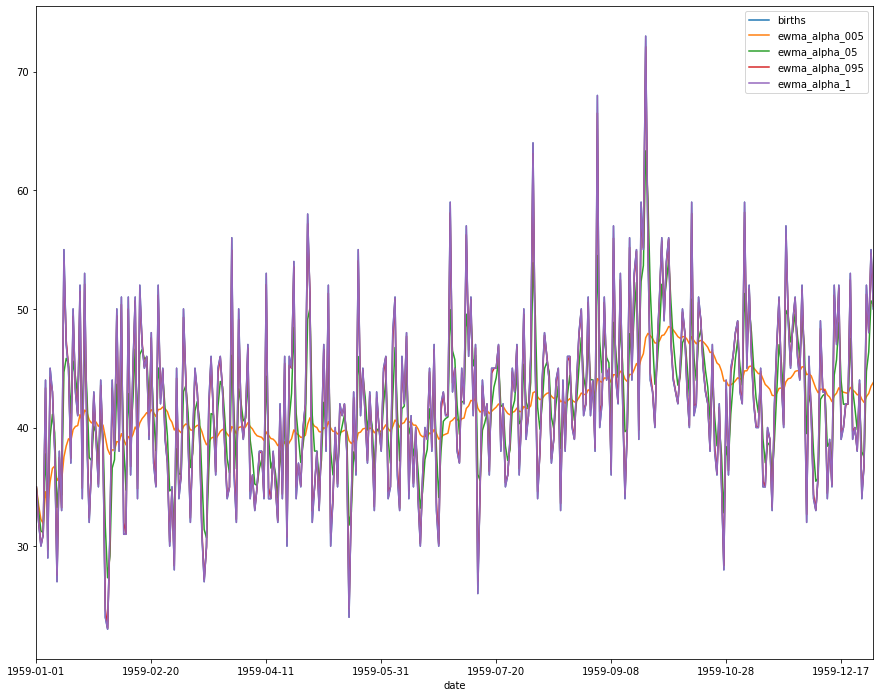

In [4]:
df_fem_births = (df_fem_births
                 .assign(ewma_alpha_005=df_fem_births.ewm(alpha=0.05).mean().values,
                         ewma_alpha_05=df_fem_births.ewm(alpha=0.5).mean().values,
                         ewma_alpha_095=df_fem_births.ewm(alpha=0.95).mean().values,
                         ewma_alpha_1=df_fem_births.ewm(alpha=1).mean().values)
                )

df_fem_births.plot(figsize=(15, 12))

We can see from above that for $ \alpha = 0.05 $ we have a smoother line, indicating that we give more importance for past values, therefore we average each point using more terms. For higher alpha values, the average is close to recent observations, then we can see a higher volatility in data. So we still need to define how we will optimize for alpha in order to produce a reliable forecast, let's work a little on that.

We can choose smoothing paramater based in preliminar knowledge on the field or minimizing erros, using for example, minimzation of sum of square of errors, like we in a regression setting.
Fortunately, statsmodels implements Simple Exponential Smoothing where you can use maximization of log-likelihood to choose best alpha parameter.

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

clf_sem = SimpleExpSmoothing(df_fem_births["births"]).fit(optimized=True)
print(f"$\alpha $ = {clf_sem.model.params['smoothing_level']}$")

$lpha $ = 0.04762762624794077$


/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



We can see that the optimisation choosed a low alpha value, indicating that the weighted average is considering a lot of different terms. Let's visualize Original versus Fitted data.

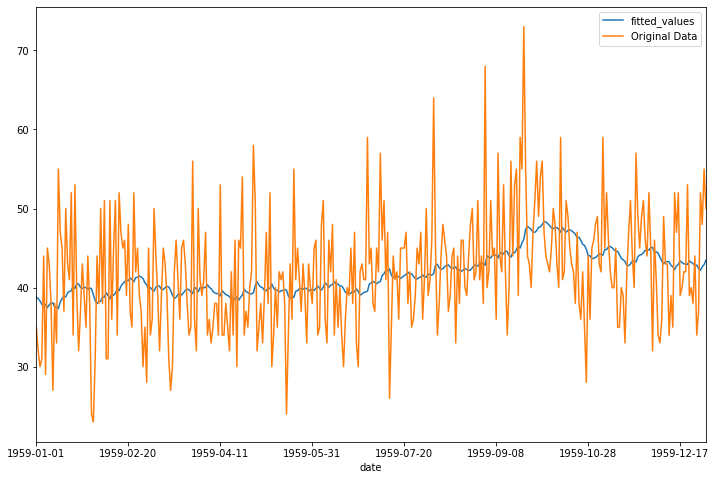

In [6]:
clf_sem.fittedvalues.to_frame(name="fitted_values").plot(figsize=(12, 8), label="Fitted Values", legend=True)
df_fem_births["births"].plot(label="Original Data", legend=True)

Producing Forecasts:

In [7]:
clf_sem.forecast(7)

1960-01-01    43.785089
1960-01-02    43.785089
1960-01-03    43.785089
1960-01-04    43.785089
1960-01-05    43.785089
1960-01-06    43.785089
1960-01-07    43.785089
Freq: D, dtype: float64

There is no need to plot forecasts. Clearly, they are all constant values, of course, we could split our data in train and test set to analyze overall performance and we will do that in the end of the notebook to compare all exponential smoothing methods.

## Methods with trend

**Holt’s linear trend method**

Holt extended simple exponential smoothing to allow forecasting data with trend. Our set of equations become then:

- Forecast Equation: $ \hat{y}_{t+h|t} = l_{t} +hb_{t} $
- Smoothing Equation: $ l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1} + b_{t-1}) $
- Trend Equation: $ b_{t} = \beta^{*}(l_{t} - l_{t-1}) + (1- \beta^{*})b_{t-1} $

Now we continuing denote $ l_{t} $ by level paramater of series at time t. $ b_{t} $ denotes estimate of the trend (slope) at time t and $ \beta^{*} $ the smoothing parameter for the trend.

**Damped trend methods**

We can also include another parameter that dampens trend estimates so we do not have an ever increasing trend in our long-run forecasts. This parameter is denoted by grek letter $\phi$.

Let's demonstrates how the model works fitting google stock close data, that clearly has a trend and no seasonal factors.

In [8]:
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing

endog = df_google_stock["close"].resample("B").mean().fillna(method="ffill").to_frame(name="close")
clf_holt = ExponentialSmoothing(endog=endog["close"], 
                                trend="add",
                                damped=False).fit(optimized=True)

clf_holt.model.params

{'smoothing_level': 1.0,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 392.4220649549009,
 'initial_slope': 0.4069996135711871,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

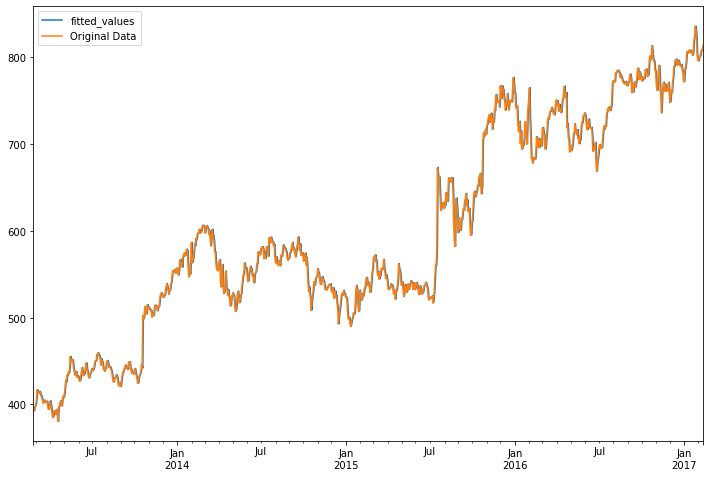

In [9]:
clf_holt.fittedvalues.to_frame(name="fitted_values").plot(figsize=(12, 8), label="Fitted Values", legend=True)
endog["close"].plot(label="Original Data", legend=True)

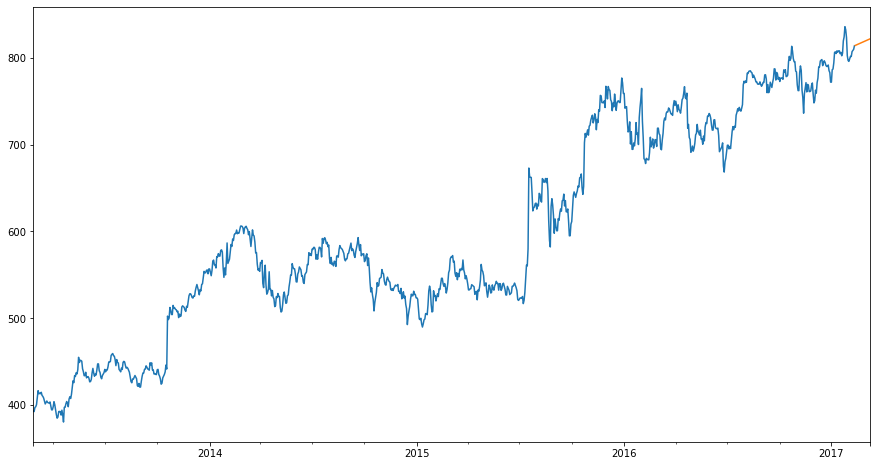

In [10]:
endog["close"].plot(figsize=(15, 8))
clf_holt.forecast(20).plot()

## Methods with seasonality

We need now incorporate in our models a seasonal component. Holt and Winters extended above Holt model to include the seasonal factor in the Forecast equation, denominated by greek letter $ \gamma $.

Also, we define our seasonal component to be either additive or multiplicative and $ m $ the frequency/period of our time series data.

**Holt-Winters' additive method**

- Forecast Equation: $ \hat{y}_{t+h|t} = l_{t} +hb_{t} +s_{t+h-m(k+1)} $
- Smoothing Equation: $ l_{t} = \alpha (y_{t} - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1}) $
- Trend Equation: $ b_{t} = \beta^{*}(l_{t} - l_{t-1}) + (1- \beta^{*})b_{t-1} $
- Seasonal Equation: $ \gamma(y_{t} - l_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-m} $

From smoothing equation ( $ l_{t} $) we can see that the weighted average now is between $ y_{t} $ for adjusted seasonality data. And if you analyze $s_{t} $ you see that you exclude trend and prior smoothing ($l_{t-1}$) from calculation as well.

For the sake of brevity, I will not include multiplicative method, but now you adjusting by a percentage value rather than in absolute terms. Of course, you can check original work in Hyndman's book. This is just a quick summary, the goal is to work with data to grasp the intuition behind math.

We have two datasets with strong seasonality, let's first apply Holt-Winters method in the one with no trend.

INFO:utils:[get_only_month_columns(df)] n_obs=74 n_col=13 time=0:00:00.000261
INFO:utils:[remove_inconsistencies(df)] n_obs=74 n_col=13 time=0:00:00.008792


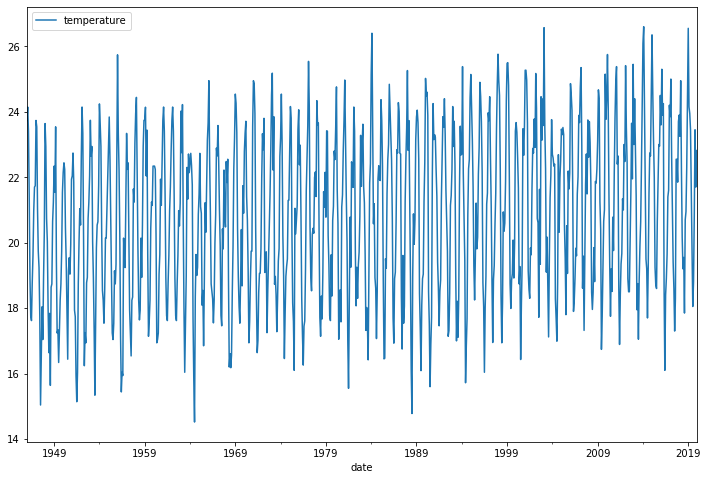

In [11]:
# Temperature data for the city of Sao Paulo only
df_temp_sp = preprocess_climate_data(df_temp_sp)
df_temp_sp.plot(figsize=(12, 8))

In [12]:
df_temp_sp = df_temp_sp.resample("MS").mean()

In [13]:
clf_hws = ExponentialSmoothing(df_temp_sp, trend=None, seasonal="additive", seasonal_periods=12)
clf_hws_fitted = clf_hws.fit(optimized=True)
clf_hws_fitted.model.params

{'smoothing_level': 0.11237241002185981,
 'smoothing_slope': nan,
 'smoothing_seasonal': 0.0,
 'damping_slope': nan,
 'initial_level': 23.473719944381674,
 'initial_slope': nan,
 'initial_seasons': array([-0.01974036,  0.26852683, -0.5056407 , -2.3603123 , -4.8461098 ,
        -5.95170949, -6.29959681, -5.14525193, -4.14207956, -2.92564608,
        -2.12023249, -0.96894701]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

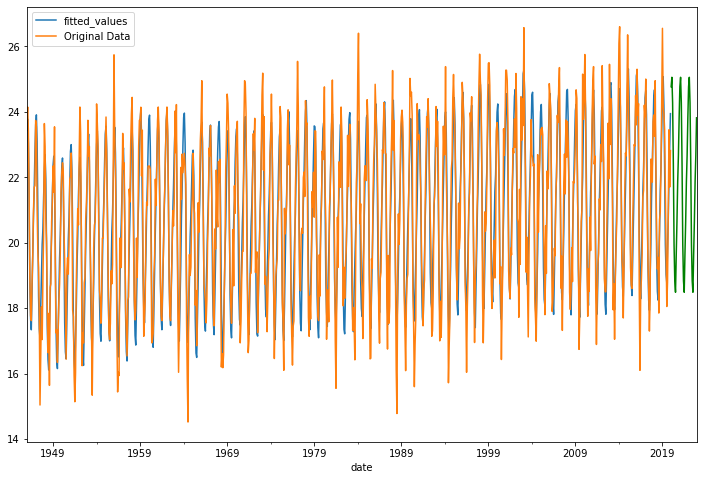

In [14]:
clf_hws_fitted.fittedvalues.to_frame(name="fitted_values").plot(figsize=(12, 8), label="Fitted Values", legend=True)
df_temp_sp["temperature"].plot(label="Original Data", legend=True)
clf_hws_fitted.forecast(36).plot(color="green")

In [15]:
df_elect_prod = df_elect_prod.rename(columns={"ipg2211a2n": "elec_production"})
df_elect_prod.index = pd.to_datetime(df_elect_prod.index)

df_elect_prod = df_elect_prod.resample("MS").mean()

In [16]:
clf_hws_mul = ExponentialSmoothing(df_elect_prod, trend="multiplicative", seasonal="multiplicative", seasonal_periods=12)
clf_hws_mul_fitted = clf_hws_mul.fit(optimized=True)
clf_hws_mul_fitted.model.params

{'smoothing_level': 0.663800693033327,
 'smoothing_slope': 4.300220381306013e-28,
 'smoothing_seasonal': 5.061077406556241e-19,
 'damping_slope': nan,
 'initial_level': 102.10118159667812,
 'initial_slope': 1.0011236500719245,
 'initial_seasons': array([0.71646346, 0.66366936, 0.61896839, 0.55600196, 0.55849691,
        0.61524947, 0.66777953, 0.66829176, 0.60529769, 0.55996383,
        0.57935396, 0.66709659]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

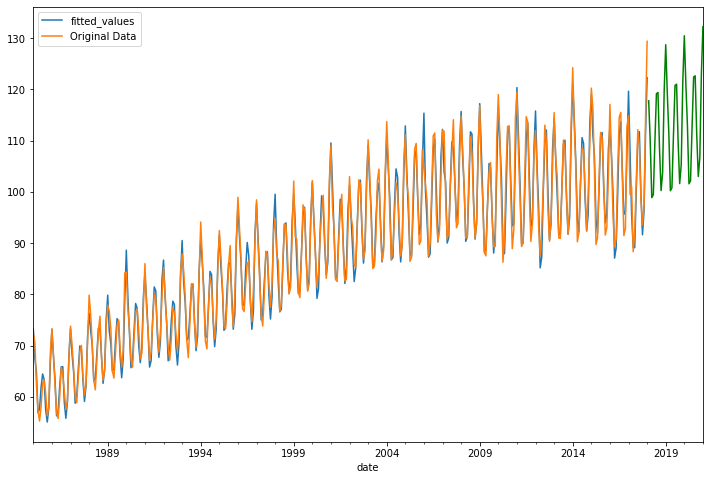

In [17]:
clf_hws_mul_fitted.fittedvalues.to_frame(name="fitted_values").plot(figsize=(12, 8), label="Fitted Values", legend=True)
df_elect_prod["elec_production"].plot(label="Original Data", legend=True)
clf_hws_mul_fitted.forecast(36).plot(color="green")

### Estimation and Model Selection

We need to create a systematic way of distinguish all models tested. To do that, we will use same nomenclature that Hyndman uses in his book:

 - ETS(A, N, N), where each segment is (Error, Trend, Seasonal) and
  - Error = {A, M}
  - Trend = {N, A, $ A_{d} $ }
  - Seasonal = {N, A, M}
  
where A is Additive, M is Multiplicative, $ A_{d} $ is Additive with damp factor, and N is None.

Model selection is based on scores such as BIC, AICc, AIC or MSE/MAE.
It is important to note that if we are using Simple Exponential Smoothing we must expect forecasts to stick at a constant level. Because at eatch t + 1, level component look to itself at level t and an observation. If we do not have a new observation, why would that change? For trend and seasonality factors, we would just get these components added to series as we see in the plots above. 